## Import packages

In [1]:
# Enable auto reloading modules (used because of custom local modules)
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import os
import glob

# Custom local modules
import utils
import ImageProcessingPipeline as Processing

%matplotlib inline

## Directories and constants

In [3]:
output_imgs_dir = os.path.join('..', 'output_images')
test_imgs_dir = os.path.join('..', 'test_images')

cal_data_file = 'calibration.pickle' # file where to save the distortion coefficients

## Camera distortion

Undistortion of camera images has already been shown in the other notebook for camera calibration. Therefore, I only wrote the function for reading out the coefficients from the saved (pickle) data and use this function later in the pipeline.

In [4]:
def undistort(image):
    dist_pickle = None
    with open(cal_data_file, 'rb') as f:
        dist_pickle = pickle.load(f)
    mtx, dist = dist_pickle['mtx'], dist_pickle['dist']
    return cv2.undistort(image, mtx, dist, None, mtx)

## View color spaces

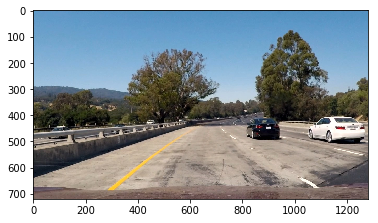

In [5]:
test_image = mpimg.imread(os.path.join(test_imgs_dir, 'test1.jpg'))
plt.imshow(test_image)

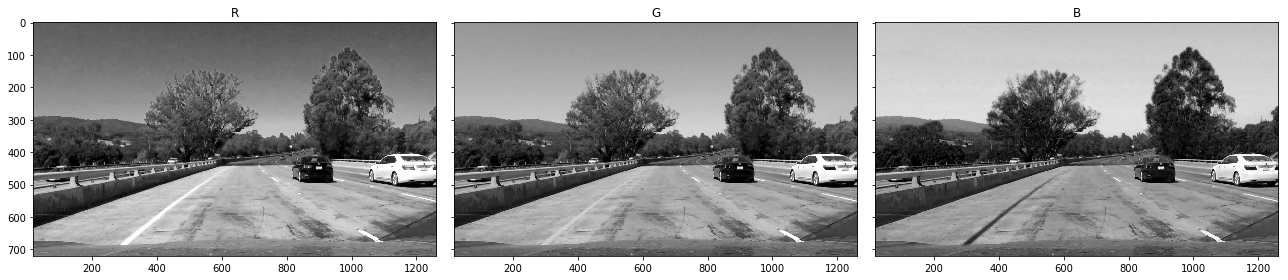

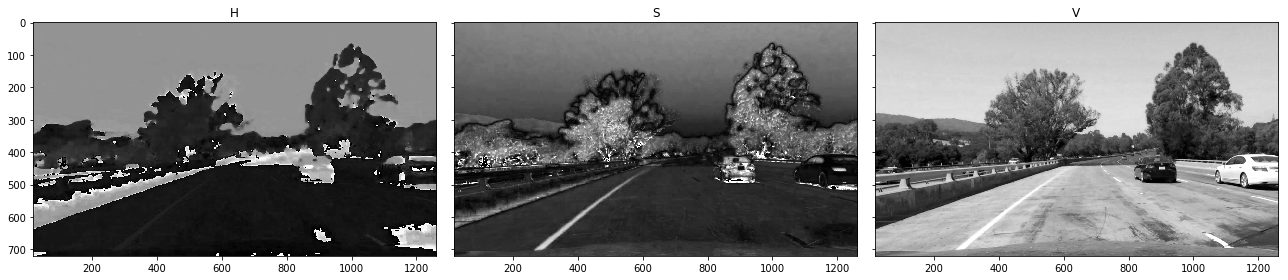

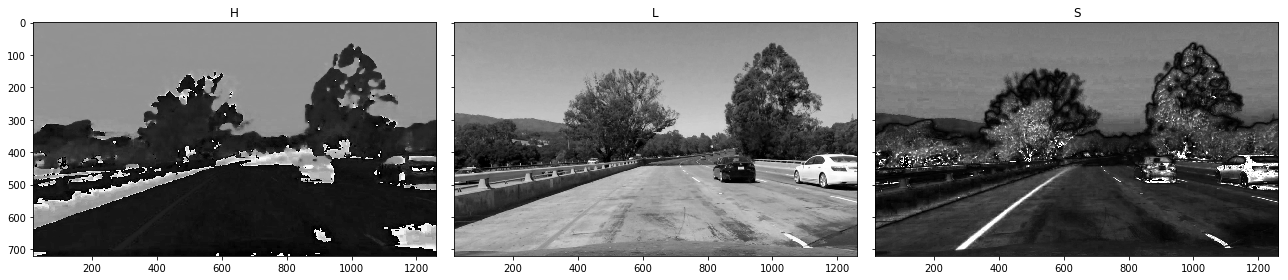

In [11]:
def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

def to_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

# Display color channels of undistorted image in different color spaces 
utils.plot_color_channels(test_image, labels=['R','G','B'])

hsv_image = Processing.ImageProcessingPipeline() \
    .register_steps([
        undistort,
        to_hsv
    ]).run(test_image)

utils.plot_color_channels(hsv_image, labels=['H','S','V'])

hls_image = Processing.ImageProcessingPipeline() \
    .register_steps([
        undistort,
        to_hls
    ]).run(test_image)

utils.plot_color_channels(hls_image, labels=['H','L','S'])

print() # prevents duplicate output of notebook

## Apply color thresholds
There are many tools out there to take advantage of HLS color space by helping to find the hue range of specific colors (e.g. https://www.w3schools.com/colors/colors_hsl.asp). For yellow colors the hue angle is approximately between 40° and 70°. However, OpenCV only has a circle up to 180° to fit it in 8 bits (0-255). So, values get divided by 2 which makes a range of 20° to 35° for yellow. We try to use it to apply an appropriate threshold for the H-channel to detect yellow lines while combining it with our threshold on the S-channel.

Although the R-channel might also be considerable, it does not show good enough results and does not seem to add any additional information to our S-threshold.

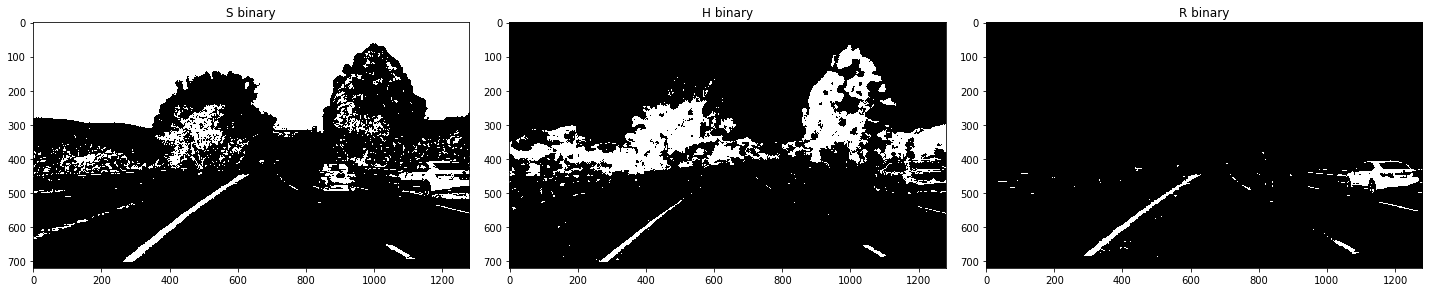

In [7]:
class color_thresholder:
    def __init__(self, channel=0, bounds=(0, 255)):
        self.channel = channel
        self.bounds = bounds
    
    def apply(self, image):
        image_channel = image[:,:,self.channel]
        binary = np.zeros_like(image_channel)
        binary[(image_channel > self.bounds[0]) & (image_channel <= self.bounds[1])] = 1
        return binary

# Applying color thresholds
thresholder = color_thresholder(2, (90, 255))
threshold_pipeline = Processing.ImageProcessingPipeline() \
    .register_step(thresholder.apply)
s_threshold = threshold_pipeline.run(hls_image)

thresholder.channel = 0
thresholder.bounds = (20, 35)
h_threshold = threshold_pipeline.run(hls_image)

thresholder.bounds = (215, 255)
r_threshold = threshold_pipeline.run(test_image)

threshold_images = [s_threshold, h_threshold, r_threshold]
threshold_labels = ['S binary', 'H binary', 'R binary']
fig = utils.plot_images_as_grid(threshold_images, threshold_labels, images_per_row=3, figsize=(20, 4), cmap='gray')
# fig.savefig('plot2test.jpg')